#Calculation of VaR for a Portfolio

Submitted By:

170123051 TANVI OHRI

170123053 TEJASVEE PANWAR

170123057 KARTIK SETHI 

In [47]:
import pandas as pd  
import numpy as np
from pandas_datareader import data, wb
import datetime
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

**What are Quantiles?**

An outcome at a given probability can be expressed using quantiles.
Let ($\Omega, F, P$) be a probability space and let $X$ : $\Omega \rightarrow R$ be a random
variable. The cumulative distribution function $F_X : \mathbb{R} \rightarrow [0, 1]$, defined by
$F_X(x) = P(X \leq x)$ is right-continuous and non-decreasing. Then, 

For $\alpha \in (0, 1)$, the number



> $q^{\alpha}$$(X)$ = $inf$ {$x : $$\alpha$ < $F_X$(x)}



is called the upper $\alpha$-quantile of X. The number



>$q_{\alpha}$$(X)$ = $inf$ {$x :         $$\alpha \leq$ $F_X$(x)}



is called the lower $\alpha$-quantile of X. Any



> $q \in [q_{\alpha}(X), q^{\alpha}(X)]$



is called an $\alpha$-quantile of X.

The image below shows the upper and lower quantiles for various distribution functions:







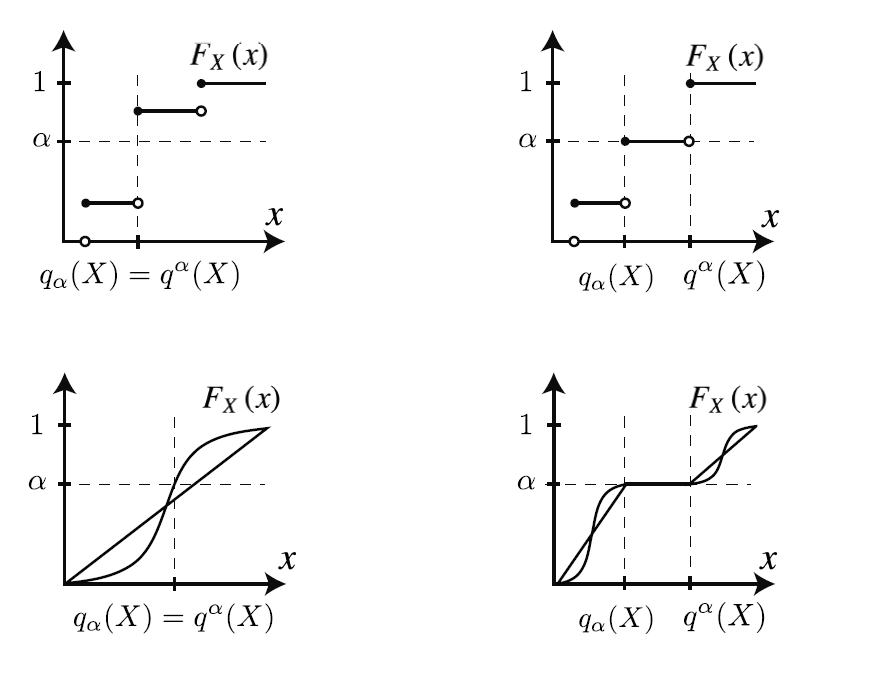


**What is VaR?**

Value at risk (VaR) is a statistic that measures and quantifies the level of financial risk within a firm, portfolio or position over a specific time frame. 

For $\alpha$ in (0, 1), we define the Value at Risk (VaR) of $X$, at confidence level
$1 - \alpha$, as



> $VaR^{\alpha}$$(X) = -$$q^{\alpha}$$(X)$ = $-inf$ {$x : $$\alpha$ < $F_X(x)$}


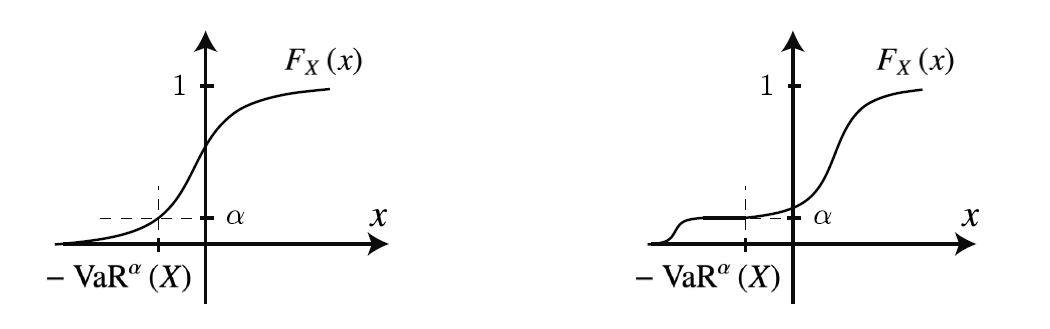

In [48]:
tickers = ['FB','AAPL', 'AMZN', 'NFLX', 'GOOG', 'MSFT']
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2019, 12, 31)
df = pd.DataFrame([data.DataReader(ticker, 'yahoo', start, end)['Adj Close'] for ticker in tickers]).T
"""
   DataReader returns a Panel object, which can be thought of as a 3D matrix. The first dimension 
   consists of the various fields Yahoo Finance returns for a given instrument, namely, the Open, High, Low, Close and 
   Adj Close (adjusted closing price) prices for each date. The second dimension contain the dates. The third one contains the instrument identifiers.
"""
df.columns = tickers

In [49]:
df.describe()

,FB,AAPL,AMZN,NFLX,GOOG,MSFT
count,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000
mean,130.621496,34.048545,984.070947,177.324537,854.370829,70.748682
std,44.592705,12.014982,566.591955,112.094569,248.999708,33.566073
min,53.529999,15.795355,286.950012,44.887142,491.201416,30.246181
25%,86.364998,24.756407,438.975006,89.359287,599.400818,42.178766
50%,129.070007,29.458752,817.880005,128.350006,797.070007,58.729496
75%,172.570000,42.311350,1602.989990,291.539993,1083.875000,97.865253
max,217.500000,72.192863,2039.510010,418.970001,1361.170044,157.293686


## VaR of individual stocks according to historical stock data

The historical method simply calculates the Quantiles/VaR for the actual historical returns. It then assumes that history will repeat itself, from a risk perspective.

In [50]:
pct_returns = df.pct_change()
"""Computes the percentage change from the immediately previous row. """
pct_returns.describe()
print(pct_returns.quantile(0.05))

FB     -0.027015
AAPL   -0.023623
AMZN   -0.027120
NFLX   -0.036799
GOOG   -0.022540
MSFT   -0.020494
Name: 0.05, dtype: float64


## VaR Using Variance Covariance Method

The variance-covariance method is an analytical way to calculate VaR. To use it we need different information than the other methods because of the assumptions it makes.



*   The variance-covariance method assumes that a stock investment's returns will be normally distributed around the mean of a normal or bell-shaped probability distribution.
*    Since returns are distributed in a normal or bell curve format, we need the standard deviation of the returns. 
*    A complicating factor of this method is that stocks can have a tendency to move up and down together, usually caused by some external factor. That means we need the covariance of returns for all of the stocks in a portfolio against all of the other stocks.

In [13]:
# Assuming stock returns are normally distributed
def portfolio_stats(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_VaR = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_VaR

In [14]:
def simulate_random_portfolios(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = portfolio_stats(weights, mean_returns, cov, alpha, days)
        results_matrix[0:3,i]=[portfolio_return, portfolio_std, portfolio_VaR]
        results_matrix[3:3+len(weights),i]=weights
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
    return results_df

In [15]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
days = 252
alpha = 0.05
results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, alpha, days)

In [16]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
min_VaR_port.to_frame().T

,ret,stdev,VaR,FB,AAPL,AMZN,NFLX,GOOG,MSFT
38730,0.295547,0.207181,0.045235,0.036745,0.288984,0.058906,0.143883,0.001522,0.469959


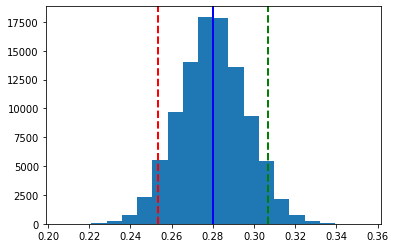

In [17]:
sample_returns=results_frame['ret']
plt.hist(sample_returns,bins=20)
plt.axvline(np.percentile(sample_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(sample_returns,95), color='g', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(sample_returns), color='b', linestyle='solid', linewidth=2)
plt.show()

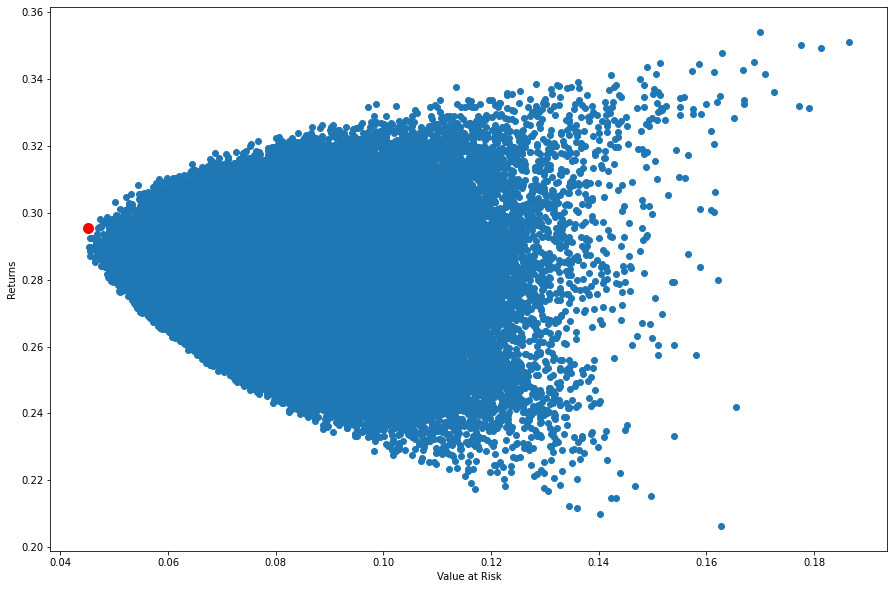

In [18]:
#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.VaR,results_frame.ret)
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],color='r',s=100)
plt.show()

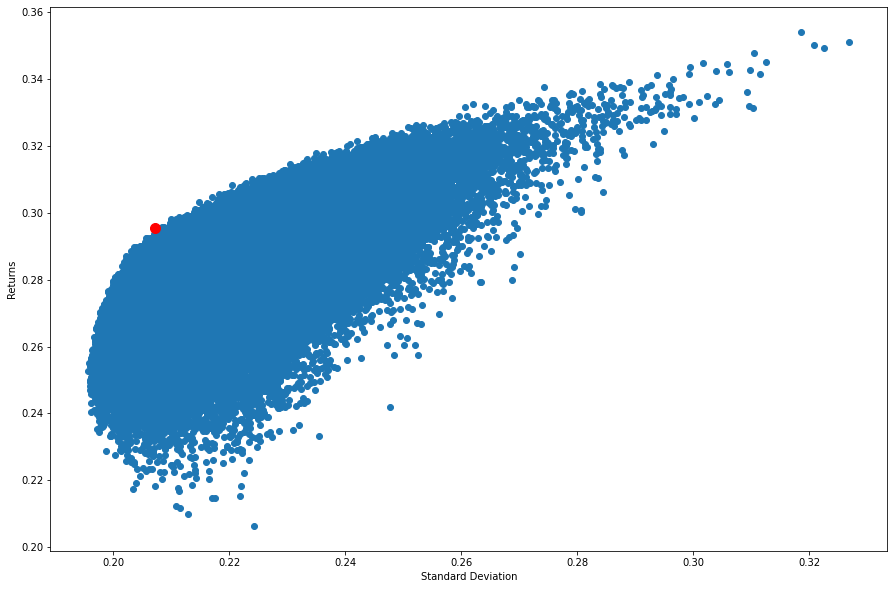

In [19]:
#create scatter plot coloured by Returns
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret)
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],color='r',s=100)
plt.show()

In [20]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_VaR = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_VaR

In [21]:
# Numerical Solver for Minimum VaR portfolio
def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [22]:
min_port_VaR = min_VaR(mean_returns, cov, alpha, days)

In [23]:
pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=tickers).T

,FB,AAPL,AMZN,NFLX,GOOG,MSFT
0,0.07,0.28,0.08,0.11,0.0,0.47


## **VaR using Monte Carlo Simulation**

### Properties of $W(t)$


1.   $W(0) = 0$
2.   $W$ has independent increments: for every $t > 0$, the future increments $W_{t+u}-W_{t}$,$ u \geq 0$ are independent of the past values $W_s$, $s\leq t$.
3. $W$ has Gaussian increments: $W_{t+u}-W_{t} \sim {\mathcal {N}}(0,u)$.
4. $W$ has continuous paths: $W_{t}$ is continuous in $t$.




###The Geometric Brownian Motion

We have assumed that the stock price follows a Geometric Brownian motion (GBM).

A stochastic process St is said to follow a GBM if it satisfies the following stochastic differential equation:


> $dS_t=\mu S_tdt+\sigma S_tdW_t$


where $W_{t}$ is a Brownian motion, and $\mu$  ('the percentage drift') and $\sigma$  ('the percentage volatility') are constants.

**Solving this SDE**

Consider an arbitrary initial value $S_0$.
This derivation requires the use of Itô calculus. Applying Itô's formula leads to <br>

> $d(\ln S_{t})=(\ln S_{t})'dS_{t}+{\frac {1}{2}}(\ln S_{t})''dS_{t}dS_{t}\\={\frac {dS_{t}}{S_{t}}}-{\frac {1}{2}}{\frac {1}{S_{t}^{2}}}dS_{t}dS_{t}$

where $dS_{t}dS_{t}$ is the quadratic variation of the SDE. 
<br><br>
Now, <br>


> $dS_{t}dS_{t}=\sigma ^{2}S_{t}^{2}dW_{t}^{2}+2\sigma S_{t}^{2}\mu dW_{t}dt+\mu ^{2}S_{t}^{2}dt^{2}$

<br>
When $dt\to 0, dt$ converges to 0 faster than $dW_{t}$, since $ dW_{t}^{2}=O(dt)$. So the above infinitesimal can be simplified by


> $dS_{t}dS_{t}=\sigma ^{2}S_{t}^{2}dt$ 

<br>
Plugging the value of $dS_{t}dS_{t}$ in the above equation and simplifying we obtain

> $ \ln {\frac {S_{t}}{S_{0}}}=(\mu -{\frac {\sigma ^{2}}{2}})t+\sigma W_{t}$.

<br>
Taking the exponential and multiplying both sides by $S_{0}$ we get

> $S_{t}=S_{0}\exp((\mu -{\frac {\sigma ^{2}}{2}})t+\sigma W_{t})$

In [24]:
def Brownian(N):
    '''
    N: Number of increments
    '''                      
    dt = 1./N                              
    b = np.random.normal(0., 1., int(N))*np.sqrt(dt)  
    W = np.cumsum(b)
    return W

In [25]:
def GBM(S0, mu, sigma, W, N):
    '''
    S0:Initial stock price
    mu:returns (drift coefficient)
    sigma:Volatility (diffusion coefficient)
    W:brownian motion
    N:number of increments
    '''
    t = np.linspace(0.,1.,N+1)
    results_matrix = np.zeros((2,N))
    for i in range(1,int(N+1)):
        drift = (mu - 0.5 * sigma**2) * t[i]
        diffusion = sigma * W[i-1]
        S_temp = S0*np.exp(drift + diffusion)
        results_matrix[0:2,i-1]=[S_temp,t[i-1]]
    results_df = pd.DataFrame(results_matrix.T,columns=['S','t'])
    return results_df


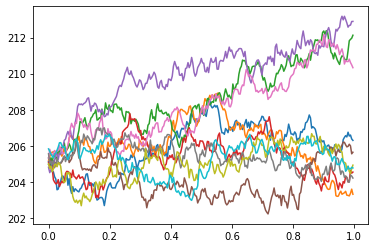

In [26]:
# Checking everything works
mu = df['FB'].pct_change().mean()
sigma = df['FB'].pct_change().std()
S0=df['FB'].loc[datetime.datetime(2019,12,31)]
for i in range(10):
    W=Brownian(252)
    df1=GBM(S0, mu, sigma,W, 252)
    plt.plot(df1['t'],df1['S'])
    

### Monte Carlo Simulations

**Lemma** : Let $X_1 , X_2 , \cdots $ be a sequence of i.i.d. random variables, $X_i: \Omega \to \mathbb{R}$, with the same distribution as $X$. Let $x \in \mathbb{R}$ be fixed. If we take a sequence of random variables $F_N(x): \Omega \to \mathbb{R}$ defined as 

$$ F_N(x) = \frac{1}{N} \sum_{i=1}^{N} 1_{\{X_i \leq x \} } $$

Then &nbsp; $F_N(x) \xrightarrow{p} F_X(x)$

Proof: $Y_i = 1_{\{X_i \leq x \}}$ and &nbsp; $ Y = 1_{\{X_i \leq x \}} $
By the weak law of large numbers $\frac{1}{N} \sum_{i=1}^{N} Y_i \xrightarrow{p} \mathbb{E}[Y]$ hence

$$ F_N(x) = \frac{1}{N} \sum_{i=1}^{N} Y_i \xrightarrow{p} \mathbb{E}[Y] = \mathbb{E}[1_{\{X_i \leq x \}}] = P(X \leq x) = F_X(x)$$
 Hence proved

 Using this result we can see that if we have $\hat{X_1}, \hat{X_2} \cdots $ as results of a simulation such that they follow the same distribution as $X$ and let
$$ \hat F_N(x) = \frac{1}{N} \sum_{i=1}^{N} 1_{\{ \hat X_i \leq x \} } $$
by the above lemma we know that 
$$ F_X(x) = \lim_{N \to \infty} \hat F_N(x)$$

Let $Y_N$ denote a discrete r.v distribution given by
$$ P(Y_N = \hat X_i) = \frac{1}{N} , \text{for } i = 1,2 \cdots N $$
the distribution function $F_{Y_N}(x) = F_N(x) $ 

Taking sufficiently large N we can approximate $Var_{\alpha} (X)$

$$ Var_{\alpha}(X) \approx Var_{\alpha}(Y_N)$$

So we can approximate VaR of simulations using the r.v. $Y_N$ and we know how to get VaR of discrete r.v. using quantiles. 

This motivates our algorithm for VaR using Monte Carlo simulation


 This method involves developing a model for future stock price returns and running multiple hypothetical trials through the model. A Monte Carlo simulation refers to any method that randomly generates trials, but by itself does not tell us anything about the underlying methodology.

#### Steps in the algorithm

1. Given a fixed weight vector and stocks
2. Get the $\mu$ and $\sigma$ for the GBM model of every stock in our portfolio
3. Final_Portfolio_value = []
4. For 1000 trials repeat:
5.  &nbsp;&nbsp;&nbsp;&nbsp; $V = 0$
6. &nbsp;&nbsp;&nbsp;&nbsp; for $i^{th}$ Stock in portfolio repeat:
7. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $T = 252$ &nbsp;get $r_i = \frac{S_i(T) - S_i(0)}{S_i(0)}$ or the stock value at final time point using GBM equation and from that get returns
8. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $V = V + w_ir_i$ i.e. $V  = \sum_{i=1}^{n} w_i r_i$
9. &nbsp;&nbsp;&nbsp;&nbsp; Append V to array of Final_portfolio_value
10. Get the $(1 - \alpha)^{th}$ percentile of Final_Portfolio_values









In [27]:
def GBM_returns(tickers,df,trials = 1000):
    mean_returns = df.pct_change().mean()    
    returns_std = df.pct_change().std()
    returns=np.zeros((len(mean_returns),trials))
    for j in range(trials):
        for i in range(len(mean_returns)):
            mu = mean_returns[tickers[i]]
            sigma = returns_std[tickers[i]]
            S0=df[tickers[i]].loc[datetime.datetime(2019,12,31)]
            W=Brownian(252)
            df_GBM=GBM(S0,mu,sigma,W,252)
            returns[i,j]=(df_GBM['S'].iloc[-1] - df_GBM['S'].iloc[0])/df_GBM['S'].iloc[0]
    returns_df=pd.DataFrame(returns.T,columns=[ticker for ticker in tickers])
    return returns_df

In [28]:
def get_VaR(weights,returns_df):
    return_arr=returns_df.to_numpy()
    portfolio_returns=return_arr*weights
    return -np.quantile(portfolio_returns,0.05)

In [29]:
def simulate_portfolios_VaR(returns_df,num_of_portfolios=1000):
    n=returns_df.shape[1]
    results_matrix = np.zeros((2+n, num_of_portfolios))
    for i in range(num_of_portfolios):
        weights = np.random.random(n)
        weights /= np.sum(weights)
        port_var=get_VaR(weights,returns_df)
        port_mean_return=np.mean(returns_df.to_numpy()*weights)
        results_matrix[0:2,i]=[port_mean_return, port_var]
        results_matrix[2:2+n,i]=weights
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','VaR'] + [ticker for ticker in tickers])
    return results_df

Text(0, 0.5, 'Returns')

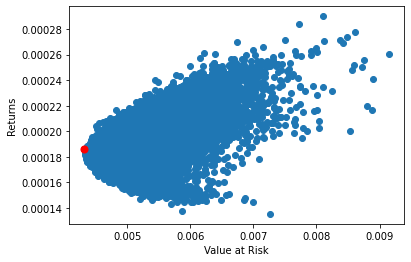

In [30]:
returns_df=GBM_returns(tickers,df,trials=1000)
results_frame=simulate_portfolios_VaR(returns_df,10000)
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
plt.scatter(results_frame.VaR,results_frame.ret)
plt.scatter(min_VaR_port[1],min_VaR_port[0],color='r',s=50)
plt.xlabel('Value at Risk')
plt.ylabel('Returns')

In [31]:
# Numerical Solver for Minimum VaR portfolio
def min_VaR(returns_df):
    num_assets = returns_df.shape[1]
    args = (returns_df)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(get_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [32]:
returns_df=GBM_returns(tickers,df,trials=1000)
min_var = min_VaR(returns_df)
weights=pd.DataFrame([round(x,3) for x in min_var['x']],index=tickers).T
print(get_VaR(weights.to_numpy(),returns_df))
weights

0.004759401540890839


,FB,AAPL,AMZN,NFLX,GOOG,MSFT
0,0.154,0.169,0.169,0.169,0.169,0.169


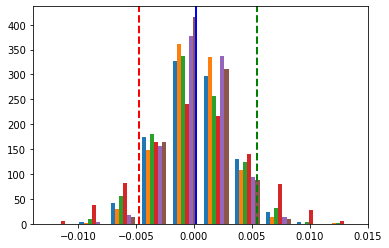

In [33]:
sample_returns=returns_df.to_numpy()*weights.to_numpy()
plt.hist(sample_returns,bins=10)
plt.axvline(np.percentile(sample_returns,5), color='r', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(sample_returns,95), color='g', linestyle='dashed', linewidth=2)
plt.axvline(np.mean(sample_returns), color='b', linestyle='solid', linewidth=2)
plt.show()

## Maximum Sharpe Ratio Portfolio

###The Sharpe Ratio 
The ratio describes how much excess return you receive for the extra volatility you endure for holding a riskier asset. You need compensation for the additional risk you take for not holding a risk-free asset.

Its formula is given by:

> $S(x) = \frac{(r_{x} - R_{f})}{\sigma}\\ \textbf{where:}\\S(x) = \text{The Sharpe Ratio of the investment}\\ x = \text{The investment}\\ r_{x} = \text{The average rate of return of }x\\ R_{f} = \text{The best available rate of return of a }\\\text{risk-free security }\\ \sigma = \text{The standard deviation of }r_{x}\\ $

  

###The Maximum Sharpe Porfolio​	 
​Maximum Sharpe Portfolio or Tangency Portfolio is a portfolio on the efficient frontier at the point where line drawn from the point (0, risk-free rate) is tangent to the efficient frontier.